In [4]:
# import computer vision functionality
from fastai.vision.all import *

In [5]:
path = Path.home()/'git/paddy'  # set path to project
Path.BASE_PATH = path  # make paths easier to read
trn_path = path/'train_images'  # training images

In [6]:
path.ls()

(#10) [Path('rn_34_6.pkl'),Path('test_images'),Path('.ipynb_checkpoints'),Path('paddy-disease-classification.zip'),Path('train.csv'),Path('sample_submission.csv'),Path('paddy.ipynb'),Path('submission.csv'),Path('train_images'),Path('cn_sm_12.pkl')]

In [7]:
trn_path.ls()

(#11) [Path('train_images/bacterial_panicle_blight'),Path('train_images/tungro'),Path('train_images/bacterial_leaf_streak'),Path('train_images/bacterial_leaf_blight'),Path('train_images/models'),Path('train_images/blast'),Path('train_images/hispa'),Path('train_images/dead_heart'),Path('train_images/downy_mildew'),Path('train_images/normal')...]

In [8]:
blb = trn_path/'bacterial_leaf_blight'  # check one group of images

## Get data

In [9]:
df = pd.read_csv(path/'train.csv')  # dataframe from training data
df

image_id                  label variety  age
0      100330.jpg  bacterial_leaf_blight   ADT45   45
1      100365.jpg  bacterial_leaf_blight   ADT45   45
2      100382.jpg  bacterial_leaf_blight   ADT45   45
3      100632.jpg  bacterial_leaf_blight   ADT45   45
4      101918.jpg  bacterial_leaf_blight   ADT45   45
...           ...                    ...     ...  ...
10402  107607.jpg                 tungro   Zonal   55
10403  107811.jpg                 tungro   Zonal   55
10404  108547.jpg                 tungro   Zonal   55
10405  110245.jpg                 tungro   Zonal   55
10406  110381.jpg                 tungro   Zonal   55

[10407 rows x 4 columns]

## Test speed of processing image files

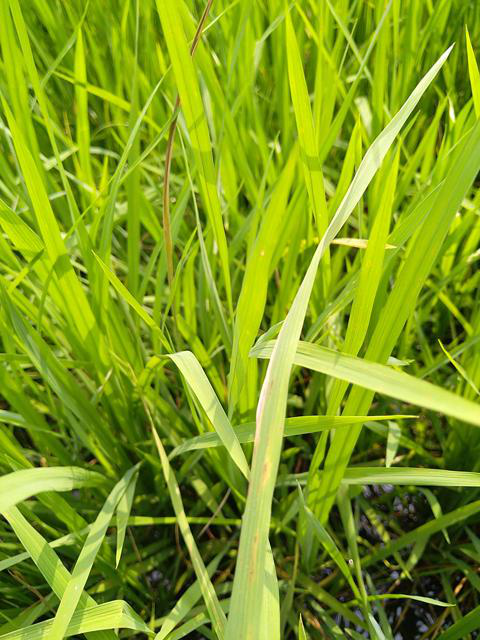

In [7]:
img = PILImage.create(blb/'100330.jpg')  # check one image
img

In [9]:
img.size

(480, 640)

In [106]:
files = get_image_files(trn_path)
files

(#10407) [Path('train_images/bacterial_panicle_blight/106542.jpg'),Path('train_images/bacterial_panicle_blight/107214.jpg'),Path('train_images/bacterial_panicle_blight/110342.jpg'),Path('train_images/bacterial_panicle_blight/101873.jpg'),Path('train_images/bacterial_panicle_blight/108893.jpg'),Path('train_images/bacterial_panicle_blight/106742.jpg'),Path('train_images/bacterial_panicle_blight/105614.jpg'),Path('train_images/bacterial_panicle_blight/107649.jpg'),Path('train_images/bacterial_panicle_blight/101765.jpg'),Path('train_images/bacterial_panicle_blight/100254.jpg')...]

In [30]:
img = PILImage.create(files[0])  # another way to get image

In [33]:
[PILImage.create(o).size for o in files[:10]]  # get size of first 10 images

[(480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640)]

In [46]:
%time sizes = [PILImage.create(o).size for o in files]  # get size of all images

CPU times: user 54.9 s, sys: 439 ms, total: 55.3 s
Wall time: 55.3 s


In [47]:
from fastcore.parallel import *

In [48]:
def f(file): return PILImage.create(file).size  # function to return image size    

In [49]:
%time sizes = parallel(f, files, n_workers=4)  # get size of all images

CPU times: user 6.75 s, sys: 1.43 s, total: 8.19 s
Wall time: 23 s


In [50]:
%time sizes = parallel(f, files, n_workers=16)  # get size of all images

CPU times: user 4.35 s, sys: 1.15 s, total: 5.5 s
Wall time: 9.46 s


In [51]:
%time sizes = parallel(f, files, n_workers=32)  # get size of all images

CPU times: user 5.09 s, sys: 1.77 s, total: 6.85 s
Wall time: 10.1 s


## Dataloaders

In [10]:
# improvement 1: data augmentation
aug_transforms(size=128, min_scale=0.75)

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 RandomResizedCropGPU -- {'size': (128, 128), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0, 'mode_mask': 'nearest', 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorMask,object) -> encodes
 decodes: ]

In [11]:
# default bs=64
dls = ImageDataLoaders.from_folder(
    trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

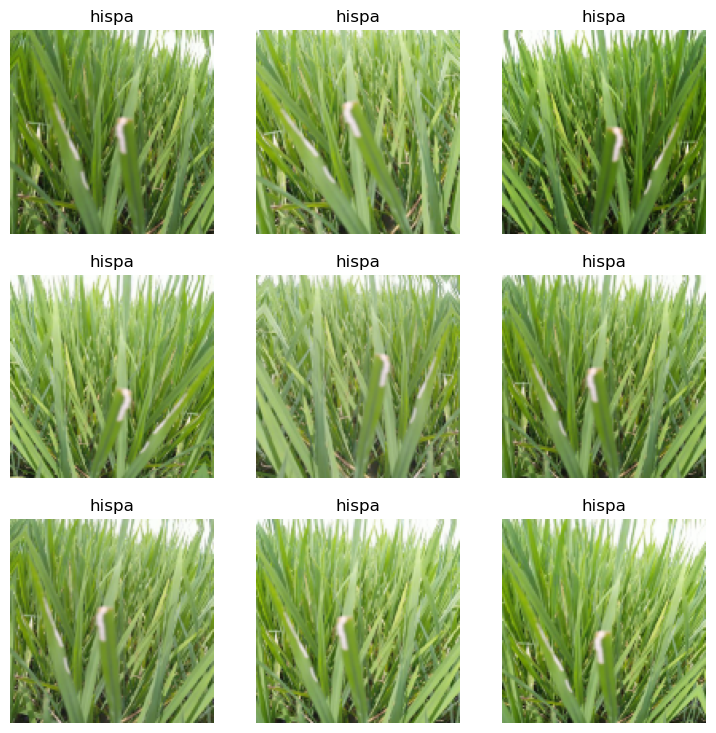

In [12]:
dls.train.show_batch(unique=True)  # show effect of augmentation

## Gpu check

In [13]:
# check gpus
torch.cuda.device_count()

1

In [14]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070'

In [10]:
# clear gpu memory
import gc
gc.collect()
torch.cuda.empty_cache()

## Learner

In [15]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

/home/judgepy/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/judgepy/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [19]:
learn.fine_tune(5)  # check training with nvidia-smi dmon - low sm% means too much processing

https://www.kaggle.com/code/jhoward/which-image-models-are-best

In [17]:
import timm  # more image models - need to install before fastai??
timm.__version__

'0.6.7'

In [18]:
timm.list_models('convnext*')  # show convnext models

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_hnf',
 'convnext_nano_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [19]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()
# half precision to speed up gpu and reduce memory?

SuggestedLRs(valley=0.0010000000474974513, slide=0.0020892962347716093)

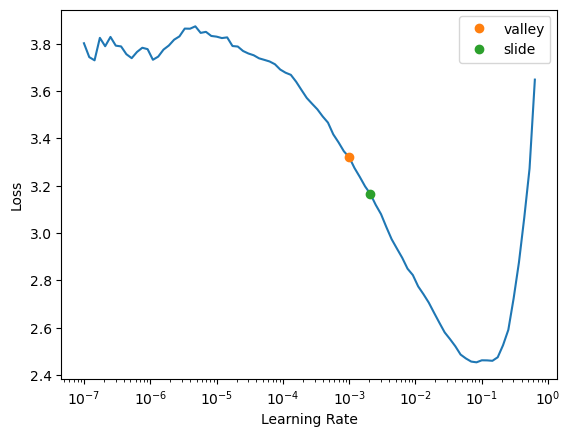

In [118]:
learn.lr_find(suggest_funcs=(valley, slide))

In [27]:
# fine_tune runs fit one cycle with different learning rates
# improvement 2 increase learning rate from default 0.002
learn.fine_tune(12, 0.01)  # runs fit one cycle with different learning rates

In [24]:
## Save learner

In [28]:
# save - only saves model and optimiser
# export - saves all of learner
learn.path = Path('.')  # store model in current directory
# learn.export('rn_34_6.pkl')
learn.export('cn_sm_12.pkl')

## Test time augmentation TTA

In [29]:
probs, targets = learn.get_preds(dl=dls.valid)  # predict on validation set
error_rate(probs, targets)  # should be same as after training

TensorBase(0.0336)

In [30]:
probs, targets = learn.tta(dl=dls.valid)  # predict with tta
error_rate(probs, targets)  # should be better - might not be using squish

TensorBase(0.0245)

## Inference

In [25]:
from fastai.data.all import *

In [31]:
test_files = get_image_files(path/'test_images')
test_files.sort()  # get test images in correct order for sumbission
test_files

(#3469) [Path('test_images/200001.jpg'),Path('test_images/200002.jpg'),Path('test_images/200003.jpg'),Path('test_images/200004.jpg'),Path('test_images/200005.jpg'),Path('test_images/200006.jpg'),Path('test_images/200007.jpg'),Path('test_images/200008.jpg'),Path('test_images/200009.jpg'),Path('test_images/200010.jpg')...]

In [32]:
# apply learner to test set
test_dl = dls.test_dl(test_files)  # test dataloader

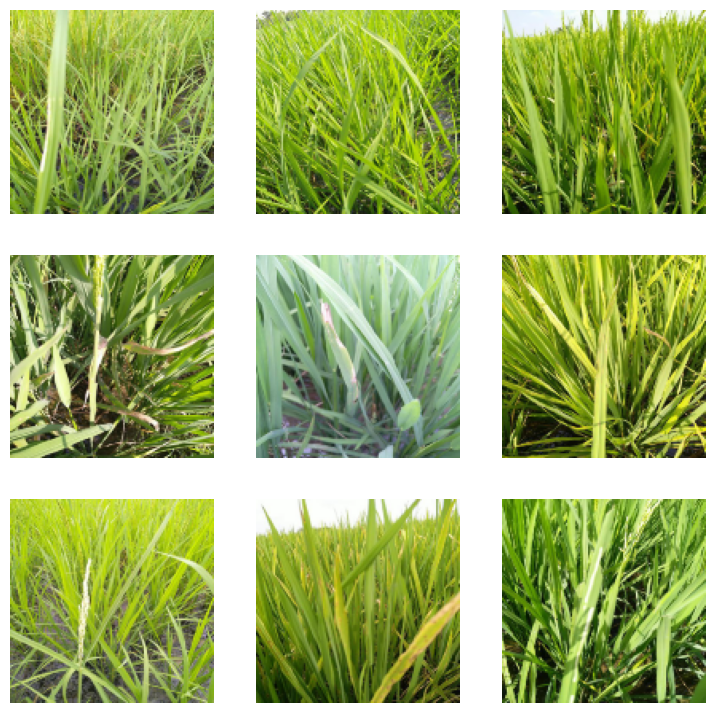

In [33]:
test_dl.show_batch()  # images do not have labels

In [34]:
# see what kaggle want for sumbmission
sample_sumission = pd.read_csv('sample_submission.csv')
sample_sumission

image_id  label
0     200001.jpg    NaN
1     200002.jpg    NaN
2     200003.jpg    NaN
3     200004.jpg    NaN
4     200005.jpg    NaN
...          ...    ...
3464  203465.jpg    NaN
3465  203466.jpg    NaN
3466  203467.jpg    NaN
3467  203468.jpg    NaN
3468  203469.jpg    NaN

[3469 rows x 2 columns]

In [35]:
# get predictions without tta
# preds = learn.get_preds(dl=test_dl, with_decoded=True)
# probs, _, indexes = preds  # probs, ?, indexes

# get predictions with tta
preds = learn.tta(dl=test_dl)  # improvement 3 use tta
probs, targets = preds  # tta does not decode highest probability into index
indexes = probs.argmax(dim=1)# manually decode probabilities

In [3]:
indexes  # indexes into vocab

NameError: name 'indexes' is not defined

In [37]:
dls.vocab  # vocab of predictions

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [38]:
# convert indexes to pandas frame
idxs = pd.Series(indexes.numpy(), name='idxs')
idxs

0       7
1       8
2       3
3       3
4       3
       ..
3464    5
3465    7
3466    8
3467    1
3468    5
Name: idxs, Length: 3469, dtype: int64

In [39]:
mapping = dict(enumerate(dls.vocab)) # dict from vocab

In [40]:
results = idxs.map(mapping)  # use dictionary for mapping

In [41]:
sample_sumission['label'] = results
sample_sumission

image_id                  label
0     200001.jpg                  hispa
1     200002.jpg                 normal
2     200003.jpg                  blast
3     200004.jpg                  blast
4     200005.jpg                  blast
...          ...                    ...
3464  203465.jpg             dead_heart
3465  203466.jpg                  hispa
3466  203467.jpg                 normal
3467  203468.jpg  bacterial_leaf_streak
3468  203469.jpg             dead_heart

[3469 rows x 2 columns]

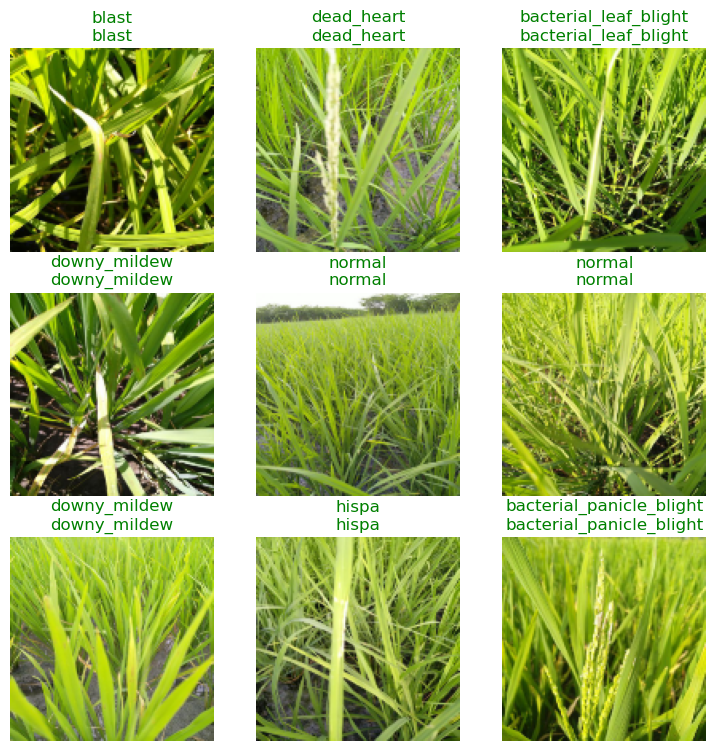

In [42]:
# visually check some results
learn.show_results()

In [43]:
sample_sumission.to_csv('submission.csv', index=False)  # save results

In [44]:
!head submission.csv  # check csv file

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


```bash
kaggle competitions -h  # help on competitions
kaggle competitions submit -f ~/git/paddy/submission.csv -m 'Initial convnext small 2 epoque fine tune' paddy-disease-classification
```
Kaggle > My submissions > Jump to leaderboard position

## Multi-head clasification

In [23]:
learn.summary()  # last layer - head 64 x 10 -> predict 10 probabilities

Sequential (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 96 x 32 x 32   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       False     
LayerNorm                                 192        True      
____________________________________________________________________________
                     64 x 32 x 32 x 384  
Linear                                    37248      False     
GELU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 32 x 96   
Linear                                    36960      False     
Dropout                            

In [21]:
# look at model
m = learn.model
m  # -> -> (0): TimmBody, (1): Sequential - aka head - last layer

Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU(approximate=none)
                (drop1): Dropout(p=0.0, inplace=False)
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
            )
            (1): ConvNeXtBlock(
              (conv_

In [24]:
head = m[1]
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1536, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [27]:
last_layer = head[-1]  # last layer is head[8] linear layer 512 x 10
last_layer

In [30]:
last_layer_parameters = list(last_layer.parameters())[0]
last_layer_parameters.shape

torch.Size([10, 512])

Previous linear layer is head[4] which is a linear layer 1536 x 512

Could remove last layer and replace it with two layers:

- 512 x 10 for the disease
- 512 x n_rice_types for the rice type

In [36]:
n_rice_types = len(df.variety.value_counts())
n_rice_types

10

In [37]:
del(head[-1])  # delete last linear layer

In [38]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1536, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
)

In [41]:
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self, m):
        """Create two linear layers"""
        super().__init__()
        # l1 for rice type
        self.l1 = nn.Linear(in_features=512, out_features=10, bias=False)
        # l1 for disease
        self.l2 = nn.Linear(in_features=512, out_features=10, bias=False)
        self.m = m
    
    def forward(self, x):
        x = self.m(x)
        x1 = self.l1(x)  # rice type output
        x2 = self.l2(x)  # disease type output
        return x1, x2
        
    

In [42]:
disease_and_type_classifier = DiseaseAndTypeClassifier(m)

In [44]:
from copy import copy
learn2 = copy(learn)

In [45]:
learn2.model = disease_and_type_classifier  # use new model

In [46]:
learn2.model

DiseaseAndTypeClassifier(
  (l1): Linear(in_features=512, out_features=10, bias=False)
  (l2): Linear(in_features=512, out_features=10, bias=False)
  (m): Sequential(
    (0): TimmBody(
      (model): ConvNeXt(
        (stem): Sequential(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (stages): Sequential(
          (0): ConvNeXtStage(
            (downsample): Identity()
            (blocks): Sequential(
              (0): ConvNeXtBlock(
                (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
                (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
                (mlp): Mlp(
                  (fc1): Linear(in_features=96, out_features=384, bias=True)
                  (act): GELU(approximate=none)
                  (drop1): Dropout(p=0.0, inplace=False)
                  (fc2): Linear(in_features=384, out_features

In [48]:
res = learn2.get_preds(dl=learn2.dls.valid)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor